# <center> Multiscale Geographically Weighted Regression Workshop </center>
## <center> Part II - Mapping Results </center>
<center> Mehak Sachdeva </center>
<center> Spatial Analysis Research Center </center>
<center> School of Geographical Sciences and Urban Planning </center>
<center> Arizona State University </center>



## Download the zipped data folder [here](https://github.com/mehak-sachdeva/MGWR_Workshop_2020/archive/master.zip) to follow along!



# Installing and importing libraries for Python for mapping results

In [1]:
#@title Python installation of custom libraries

! pip install -U mgwr
! pip install geopandas
! pip install pyshp
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz 2>/dev/null | tar xz
!apt-get install -qq g++ make
import os
os.chdir('/content/spatialindex-src-1.8.5')
!./configure 2>&1 >/dev/null && make 2>&1 >/dev/null && make install && ldconfig
!pip install -q rtree
!pip install matplotlib_scalebar

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 2.4MB 6.1MB/s 
     |████████████████████████████████| 215kB 29.8MB/s 
  Created wheel for mgwr: filename=mgwr-2.1.2-cp37-none-any.whl size=46374 sha256=dea8d6d143cf2460d09217a7a83a579a2f75d4bbd434378897835d69cdcdff1a
  Stored in directory: /root/.cache/pip/wheels/cf/11/e3/68692f1c637b23a8e2c6e200f6183c3502718b5f7de6dc630d
  Created wheel for spglm: filename=spglm-1.0.8-cp37-none-any.whl size=38807 sha256=4fb1784d2602eed419e4cd7ba2958a142bd39e34b7d5b42778364c316b795bfb
  Stored in directory: /root/.cache/pip/wheels/cd/1e/e3/c68bde79087fdc97cf65ec86e6d1d7ed2171e1baa1b0482363
Successfully built mgwr spglm
     |████████████████████████████████| 1.0MB 6.7MB/s 
     |████████████████████████████████| 14.8MB 260kB/s 
     |████████████████████████████████| 6.5MB 37.1MB/s 
     |████████████████████████████████| 225kB 5.3MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37

In [2]:
#@title Python imports
# A bit of imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load in the r magic
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
sns.set(color_codes=True)
from sklearn import linear_model
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar
import statsmodels.api as statm

import libpysal as ps
from mgwr.gwr import GWR
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Gaussian, Binomial, Poisson
import multiprocessing as mp
pool = mp.Pool()
import io

from google.colab import files
from IPython.display import Image

In [3]:
#Upload the results .csv file output from the MGWR software
uploaded = files.upload()

Saving MGWR_HIV_result_results.csv to MGWR_HIV_result_results.csv


In [4]:
#@title Importing the results csv file for mapping
census = pd.read_csv(io.StringIO(uploaded['MGWR_HIV_result_results.csv'].decode('utf-8')),sep=',')
census.columns

Index(['geoid', 'x_coor', 'y_coor', 'y', 'ols_residual', 'mgwr_yhat',
       'mgwr_residual', 'localR2', 'beta_Intercept',
       'beta_%_no_health_insurance', 'beta_%_below_poverty',
       'beta_%_vacant_housing', 'beta_%_white', 'se_Intercept',
       'se_%_no_health_insurance', 'se_%_below_poverty', 'se_%_vacant_housing',
       'se_%_white', 't_Intercept', 't_%_no_health_insurance',
       't_%_below_poverty', 't_%_vacant_housing', 't_%_white', 'p_Intercept',
       'p_%_no_health_insurance', 'p_%_below_poverty', 'p_%_vacant_housing',
       'p_%_white', 'sumW_Intercept', 'sumW_%_no_health_insurance',
       'sumW_%_below_poverty', 'sumW_%_vacant_housing', 'sumW_%_white'],
      dtype='object')

In [5]:
# Here we are exluding rows whose t-values are not significant enough
b_cols = ['beta_Intercept','beta_%_no_health_insurance','beta_%_below_poverty','beta_%_vacant_housing','beta_%_white']
bt_cols = ['bt_Intercept','bt_%_no_health_insurance','bt_%_below_poverty','bt_%_vacant_housing','bt_%_white']
t_cols = ['t_Intercept','t_%_no_health_insurance','t_%_below_poverty','t_%_vacant_housing','t_%_white']

t_crit = [2.790, 2.035, 2.766, 2.205, 2.794]

In [6]:
for i in range(len(b_cols)):
    census.loc[census[t_cols[i]] >=t_crit[i], bt_cols[i]] = census[b_cols[i]]
    census.loc[census[t_cols[i]] <=-t_crit[i], bt_cols[i]] = census[b_cols[i]]

In [7]:
uploaded = files.upload()
#upload the census_tract files from the downloaded folder

Saving zipcode_NYC.cpg to zipcode_NYC.cpg
Saving zipcode_NYC.dbf to zipcode_NYC.dbf
Saving zipcode_NYC.prj to zipcode_NYC.prj
Saving zipcode_NYC.sbn to zipcode_NYC.sbn
Saving zipcode_NYC.sbx to zipcode_NYC.sbx
Saving zipcode_NYC.shp to zipcode_NYC.shp
Saving zipcode_NYC.shp.xml to zipcode_NYC.shp.xml
Saving zipcode_NYC.shx to zipcode_NYC.shx


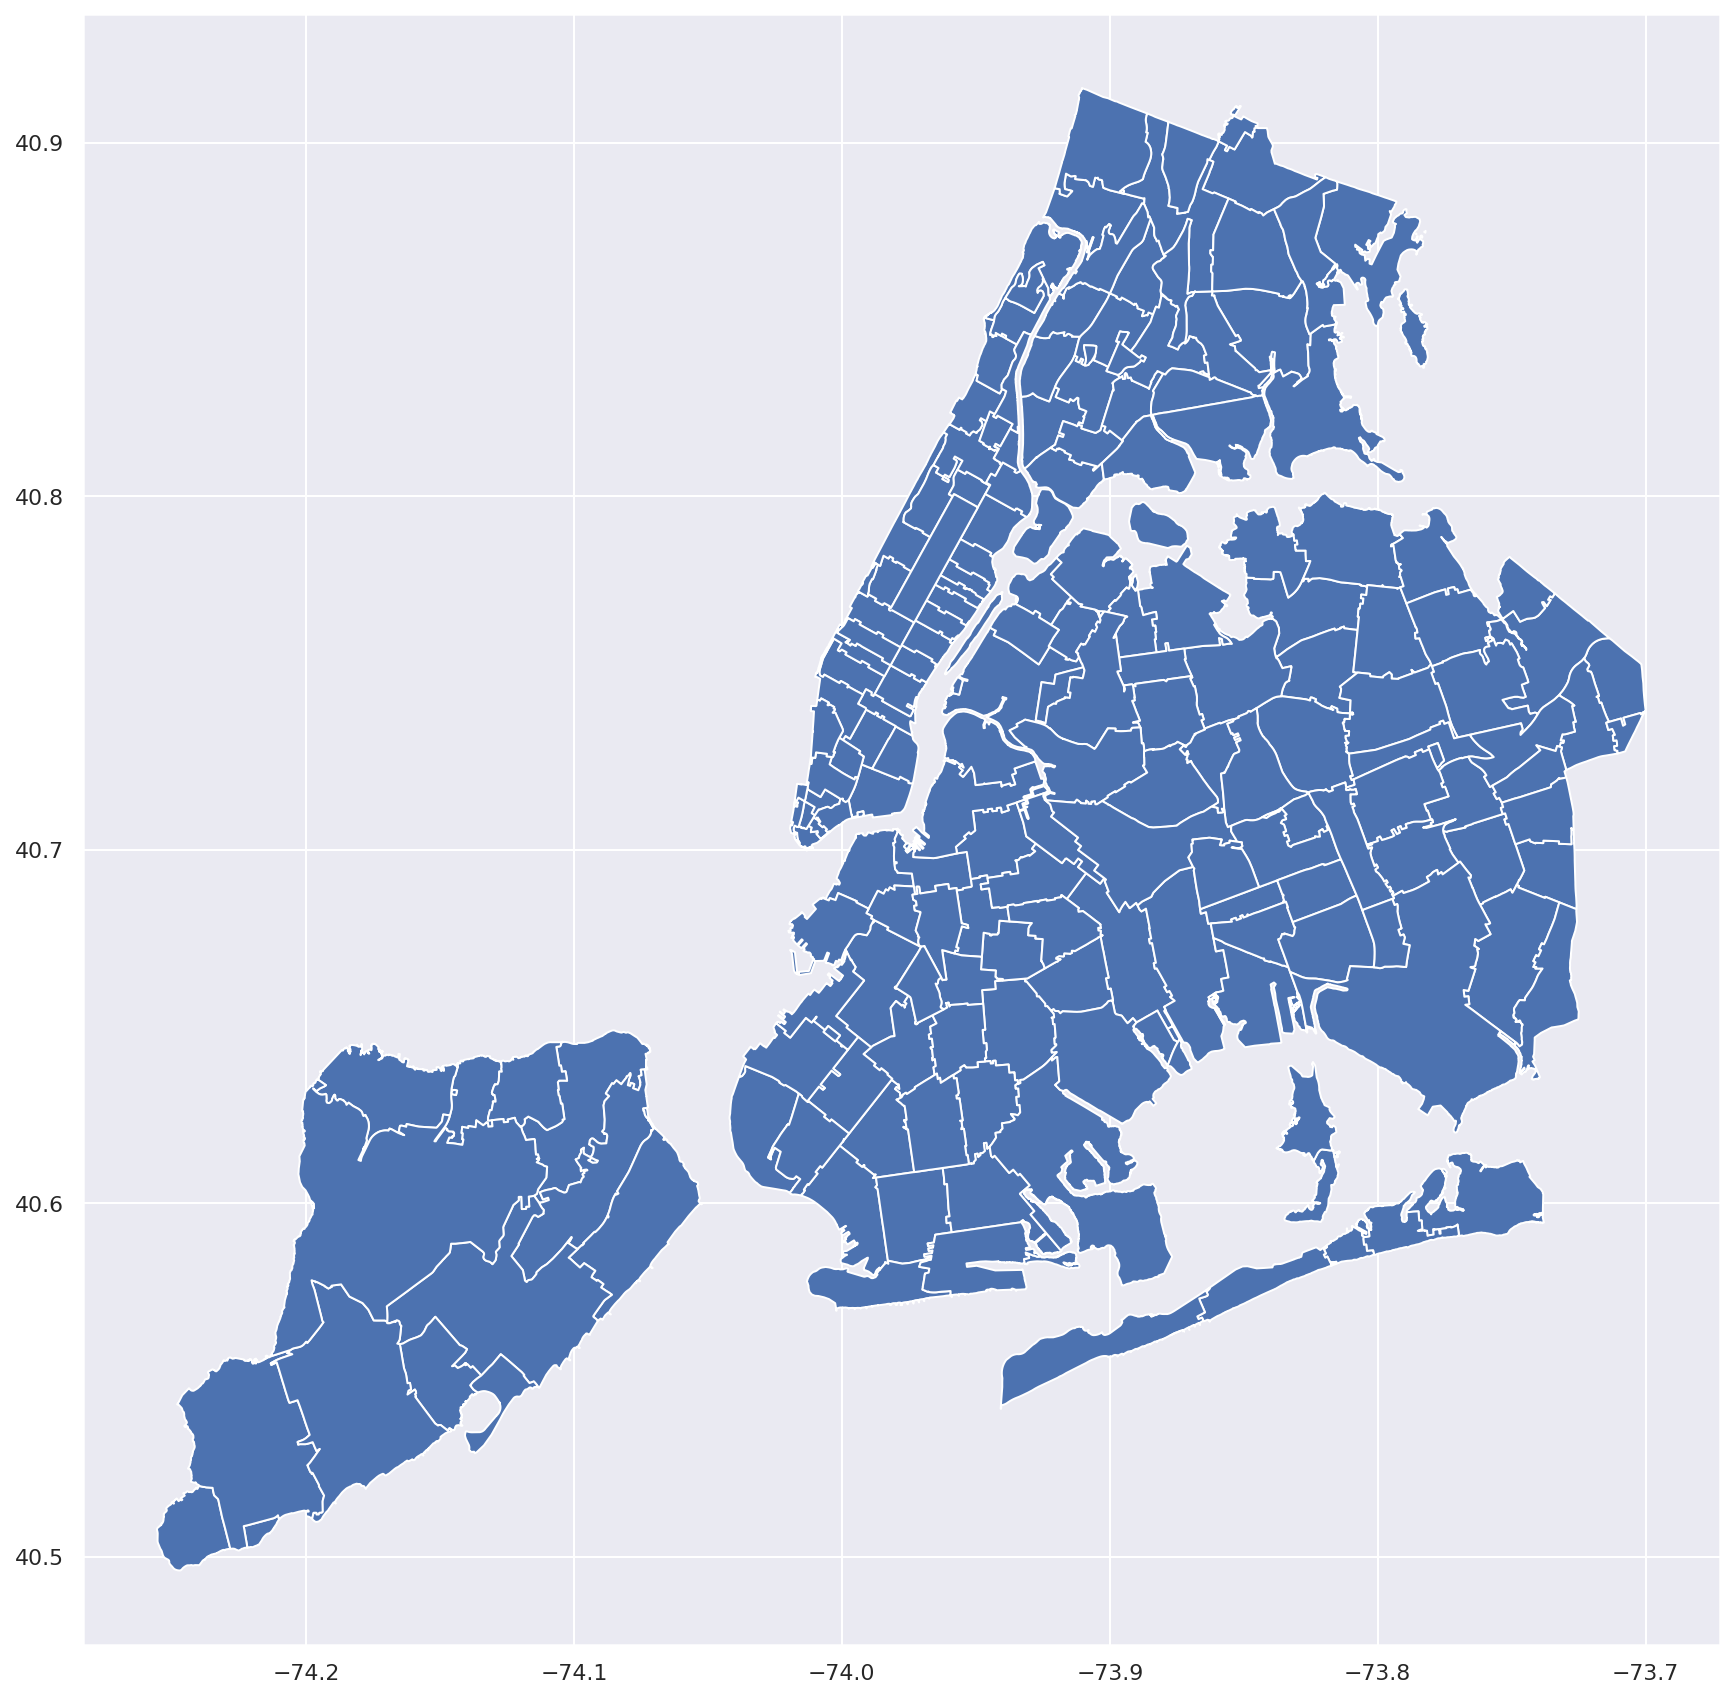

In [8]:
c='zipcode_NYC.shp'
crs = {'EPSG':'4326'}
geo = gpd.read_file(c,crs=crs)[['geometry','GEOID10']]
fig,ax = plt.subplots(figsize=(20,15))
geo.plot(ax=ax)

In [9]:
geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
census.columns

Index(['geoid', 'x_coor', 'y_coor', 'y', 'ols_residual', 'mgwr_yhat',
       'mgwr_residual', 'localR2', 'beta_Intercept',
       'beta_%_no_health_insurance', 'beta_%_below_poverty',
       'beta_%_vacant_housing', 'beta_%_white', 'se_Intercept',
       'se_%_no_health_insurance', 'se_%_below_poverty', 'se_%_vacant_housing',
       'se_%_white', 't_Intercept', 't_%_no_health_insurance',
       't_%_below_poverty', 't_%_vacant_housing', 't_%_white', 'p_Intercept',
       'p_%_no_health_insurance', 'p_%_below_poverty', 'p_%_vacant_housing',
       'p_%_white', 'sumW_Intercept', 'sumW_%_no_health_insurance',
       'sumW_%_below_poverty', 'sumW_%_vacant_housing', 'sumW_%_white',
       'bt_Intercept', 'bt_%_no_health_insurance', 'bt_%_below_poverty',
       'bt_%_vacant_housing', 'bt_%_white'],
      dtype='object')

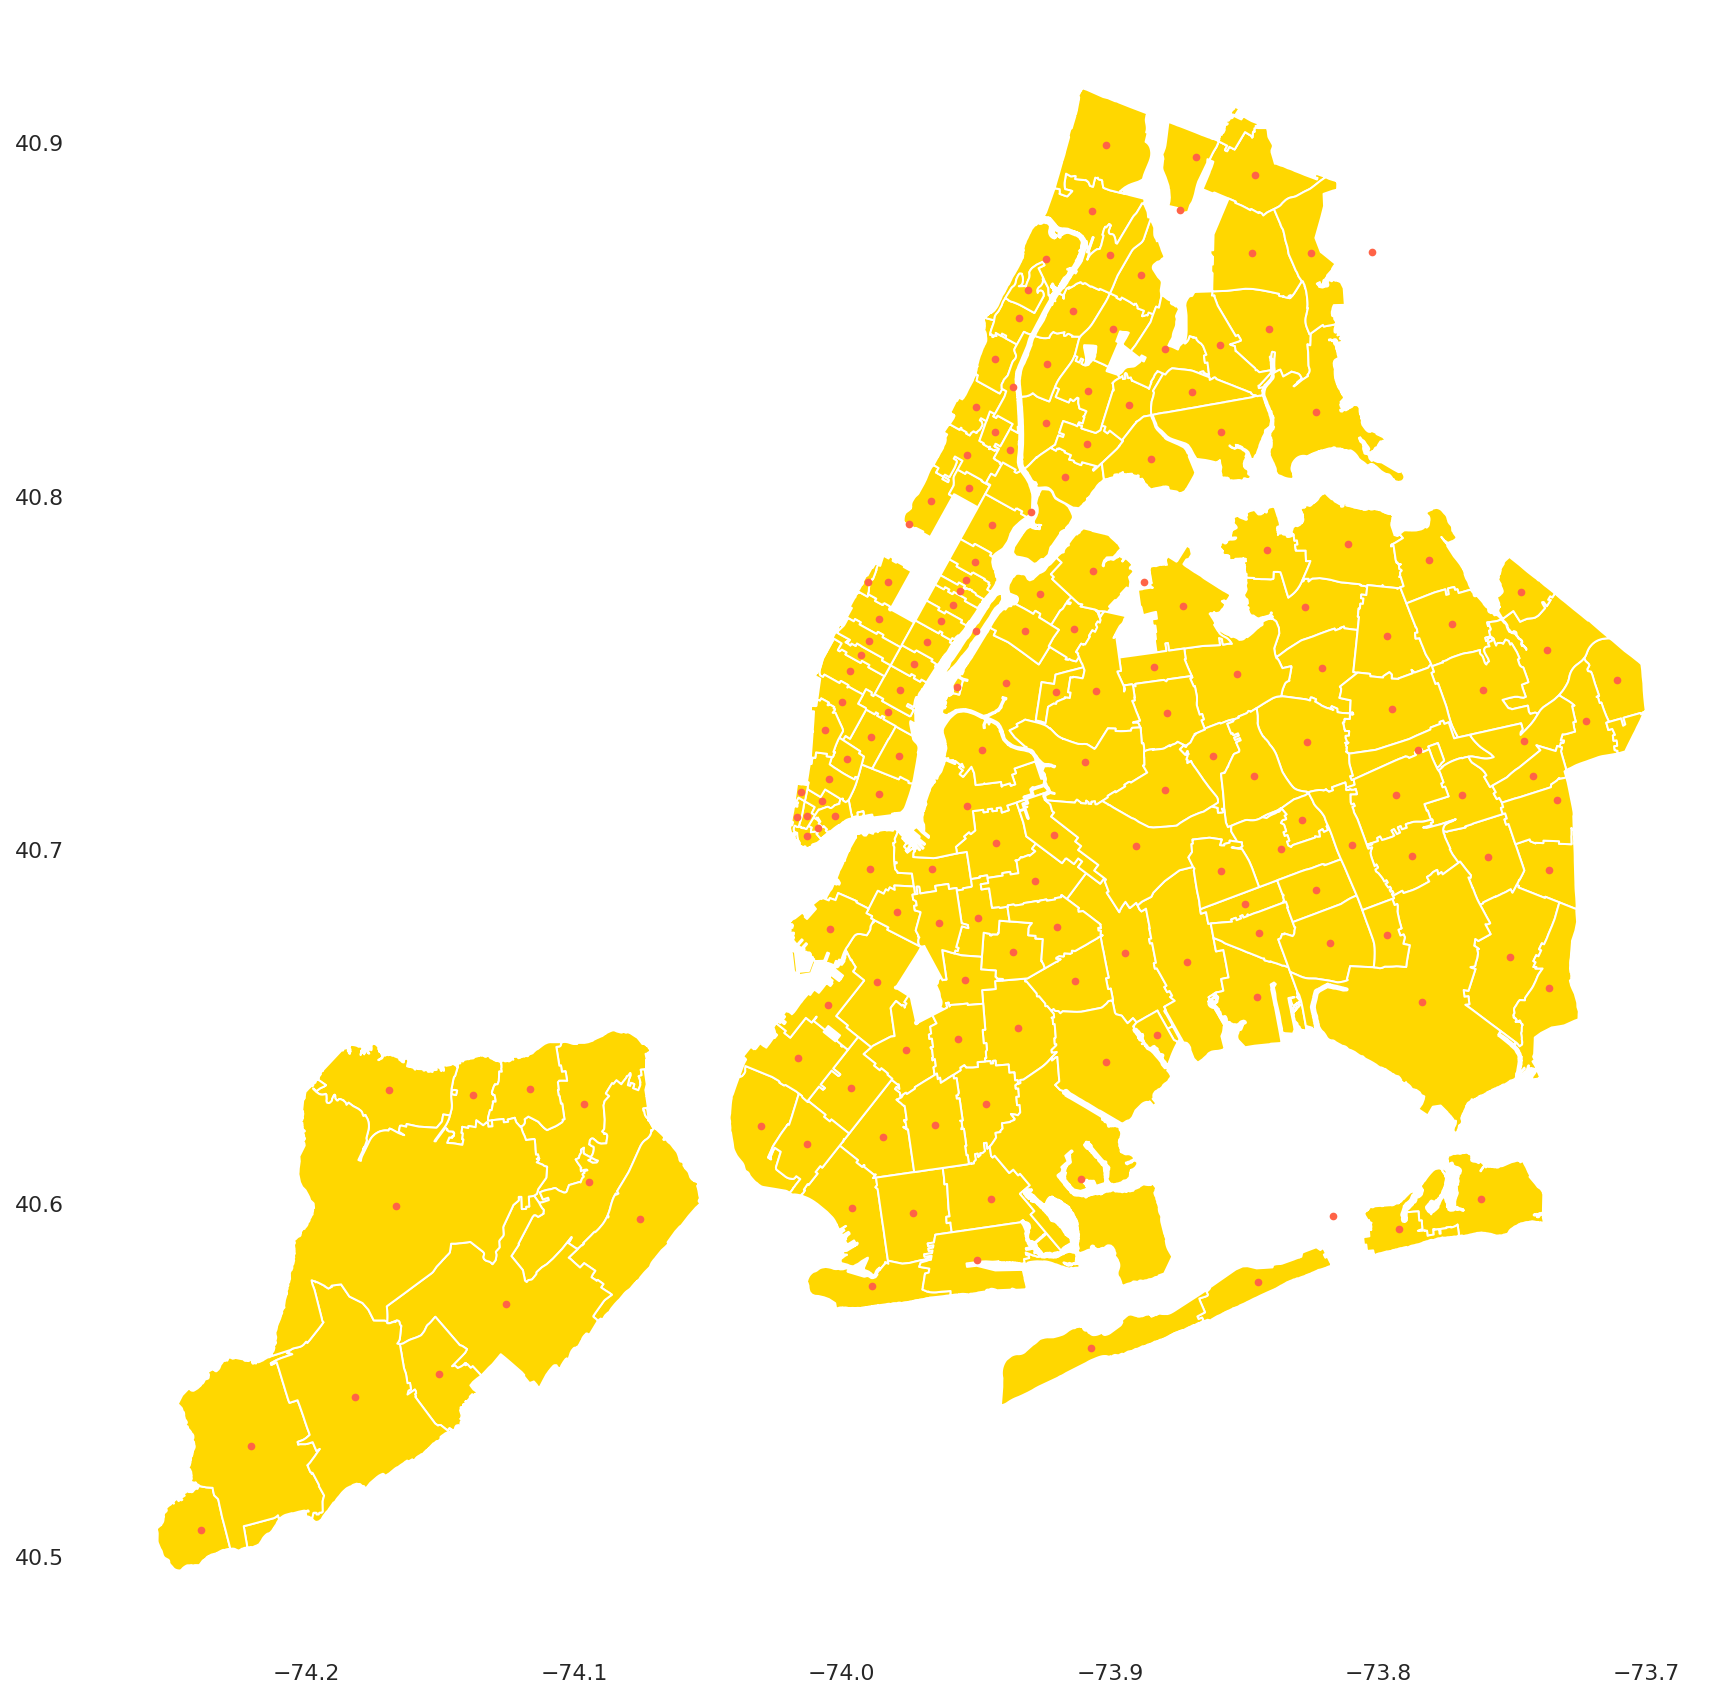

In [12]:
coords = np.array(list(zip(census['x_coor'],census['y_coor'])))
geom_points = [Point(xy) for xy in coords]
geo_df = gpd.GeoDataFrame(census,crs={'init':'epsg:4326'},geometry=geom_points)
geo_df = geo_df.rename(columns={'geoid':'GEOID10'})
geo_df = geo_df.to_crs(epsg=4326)
final_geo = gpd.sjoin(geo, geo_df, how='inner',op='contains',lsuffix='left',rsuffix='right')


fig,ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('white')
final_geo.plot(ax=ax, color='gold')
geo_df.plot(ax=ax, markersize=8,alpha=1,color='tomato',marker="o")

In [13]:
final_geo.head()

,geometry,GEOID10_left,index_right,GEOID10_right,x_coor,y_coor,y,ols_residual,mgwr_yhat,mgwr_residual,localR2,beta_Intercept,beta_%_no_health_insurance,beta_%_below_poverty,beta_%_vacant_housing,beta_%_white,se_Intercept,se_%_no_health_insurance,se_%_below_poverty,se_%_vacant_housing,se_%_white,t_Intercept,t_%_no_health_insurance,t_%_below_poverty,t_%_vacant_housing,t_%_white,p_Intercept,p_%_no_health_insurance,p_%_below_poverty,p_%_vacant_housing,p_%_white,sumW_Intercept,sumW_%_no_health_insurance,sumW_%_below_poverty,sumW_%_vacant_housing,sumW_%_white,bt_Intercept,bt_%_no_health_insurance,bt_%_below_poverty,bt_%_vacant_housing,bt_%_white
0,"POLYGON ((-73.98775 40.74407, -73.98819 40.743...",10001,0,10001,-73.9971,40.7507,1.733879,1.846619,0.673889,1.059990,0.381346,0.776028,-0.104440,0.294972,0.047765,-0.171398,0.122045,0.055497,0.123184,0.063713,0.149080,6.358542,-1.881896,2.394560,0.749693,-1.149702,1.700000e-09,0.061501,0.017691,0.454440,0.251827,20.699430,111.292159,20.699430,83.701256,20.699430,0.776028,NaN,NaN,NaN,NaN
1,"POLYGON ((-73.99606 40.70921, -73.99608 40.709...",10002,1,10002,-73.9862,40.7158,0.204352,-0.581094,0.868143,-0.663790,0.308469,0.557114,-0.104843,0.173473,0.044522,-0.181137,0.119567,0.055469,0.123234,0.061706,0.147980,4.659442,-1.890124,1.407676,0.721520,-1.224065,6.230000e-06,0.060385,0.160991,0.471547,0.222564,18.684196,111.222760,18.684196,84.864779,18.684196,0.557114,NaN,NaN,NaN,NaN
2,"POLYGON ((-73.98859 40.72301, -73.98864 40.722...",10003,2,10003,-73.9892,40.7318,0.413215,0.816959,0.483245,-0.070030,0.346948,0.689844,-0.105048,0.221849,0.046487,-0.145232,0.122906,0.055444,0.124845,0.063244,0.149573,5.612790,-1.894679,1.777003,0.735037,-0.970979,7.620000e-08,0.059775,0.077295,0.463296,0.332891,20.074133,113.076744,20.074133,83.197819,20.074133,0.689844,NaN,NaN,NaN,NaN
3,"MULTIPOLYGON (((-74.00801 40.70799, -74.00827 ...",10004,3,10004,-74.0130,40.7038,0.241776,0.437435,0.230312,0.011465,0.310457,0.480593,-0.099393,0.205371,0.041218,-0.208019,0.117126,0.055806,0.126466,0.060552,0.147069,4.103200,-1.781046,1.623920,0.680708,-1.414429,6.220000e-05,0.076630,0.106183,0.496951,0.159003,18.952519,100.464541,18.952519,81.937470,18.952519,0.480593,NaN,NaN,NaN,NaN
4,"POLYGON ((-74.00766 40.70320, -74.00783 40.703...",10005,4,10005,-74.0089,40.7061,-0.095278,-0.231955,0.362705,-0.457984,0.312035,0.499745,-0.100446,0.210017,0.041638,-0.200322,0.117643,0.055726,0.126933,0.060756,0.147382,4.247975,-1.802484,1.654547,0.685334,-1.359202,3.490000e-05,0.073180,0.099799,0.494035,0.175822,19.546115,102.851470,19.546115,82.496685,19.546115,0.499745,NaN,NaN,NaN,NaN


In [15]:
print(final_geo['bt_%_vacant_housing'].values)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.15138307        nan        nan        nan
        nan        nan        nan        nan        nan       

# Plotting the results 

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# # upload the more_labels_new files from the downloaded folder

Saving more_labels_new.cpg to more_labels_new (1).cpg
Saving more_labels_new.csv to more_labels_new (1).csv
Saving more_labels_new.dbf to more_labels_new (1).dbf
Saving more_labels_new.prj to more_labels_new (1).prj
Saving more_labels_new.sbn to more_labels_new (1).sbn
Saving more_labels_new.sbx to more_labels_new (1).sbx
Saving more_labels_new.shp to more_labels_new (1).shp
Saving more_labels_new.shx to more_labels_new (1).shx


In [16]:
import scipy as sp
import shapefile as shp

import matplotlib as mpl
import matplotlib.pyplot as plt
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

In [18]:
# label = gpd.read_file("more_labels_new.shp")

In [17]:
# label=label.to_crs(epsg=3857)
# label=label.drop(label.index[3])
# label=label.reset_index()
# label=label.drop(label.index[5])
# label=label.reset_index()
# label

In [19]:
def mapp(col,name,color,normal=False):  
    vmi=min(col[name])
    vma=max(col[name])
    figsize=(14,10)
    colors = 10
    norm = MidpointNormalize(vmin=vmi, vmax=vma, midpoint=0)
    colors = 6
    fig, ax = plt.subplots(1, figsize=(14, 14))

    if normal==True:
        col.plot(column=name, ax=ax,cmap=color,figsize=figsize,k=colors, linewidth=0.5,norm=norm)
    else:
        col.plot(column=name, ax=ax,cmap=color,figsize=figsize,k=colors, linewidth=0.5)

    ax.axis("off")

    Scalebar = ScaleBar(100000,location='lower left') # 1 pixel = 0.2 meter
    scatter = ax.collections[-1]

    plt.colorbar(scatter, ax=ax, extend='min',orientation='horizontal',fraction=0.046, pad=0.04)
    col.boundary.plot(ax=ax,color='grey',alpha=0.2)

    texts = []
    for x, y, lab in zip(label.geometry.x, label.geometry.y, label["names"]):
      texts.append(plt.text(x-1500, y-700, lab, fontsize = 8,horizontalalignment='left',verticalalignment='baseline',bbox=dict(facecolor='white', alpha=0.7,linewidth=0.0)))
    label.plot(ax=ax,alpha=1,color='black',linewidth=0.4)
    

    plt.show()

NameError: ignored

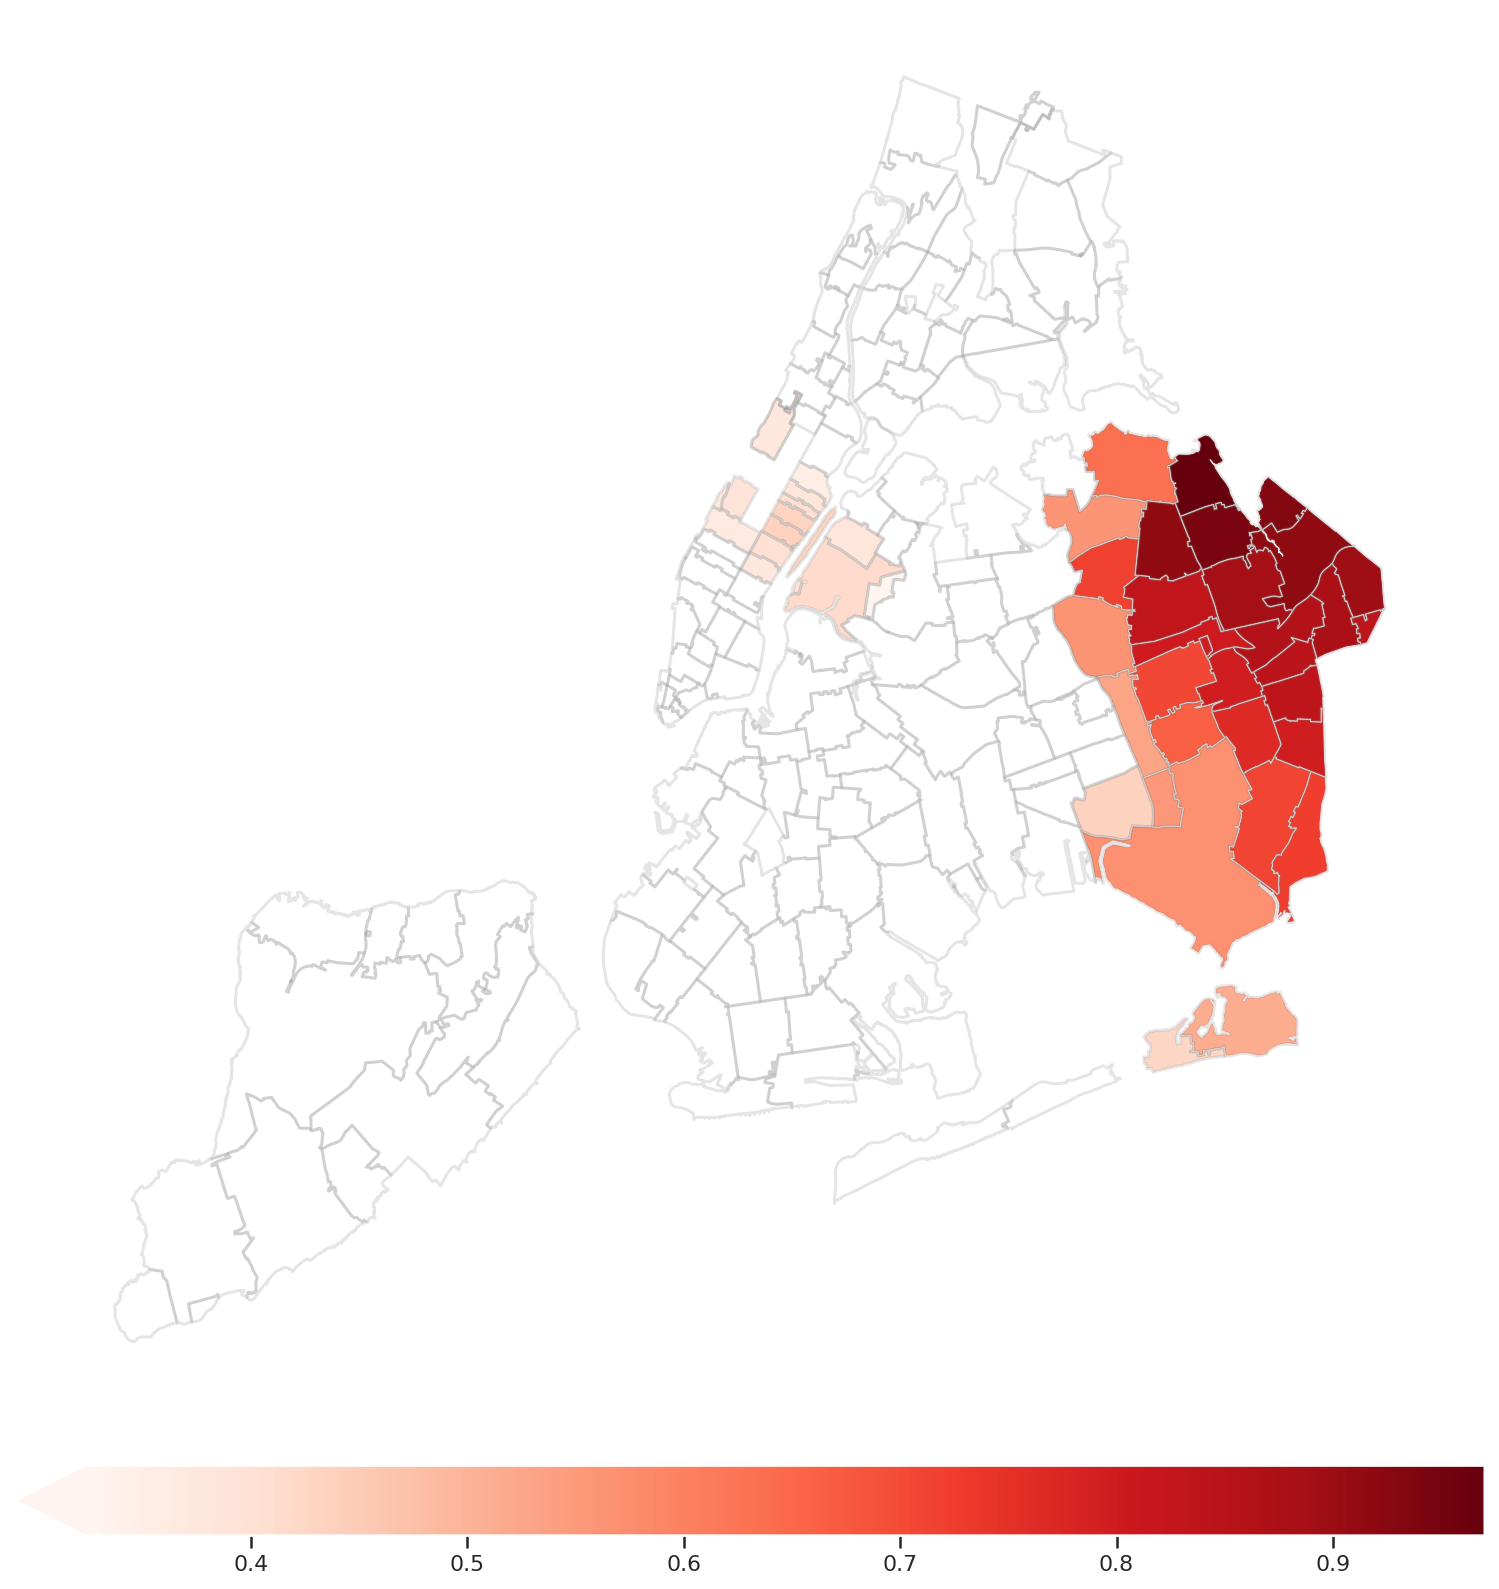

In [20]:
mapp(col=final_geo,name='bt_%_below_poverty',color='Reds',normal=False)


NameError: ignored

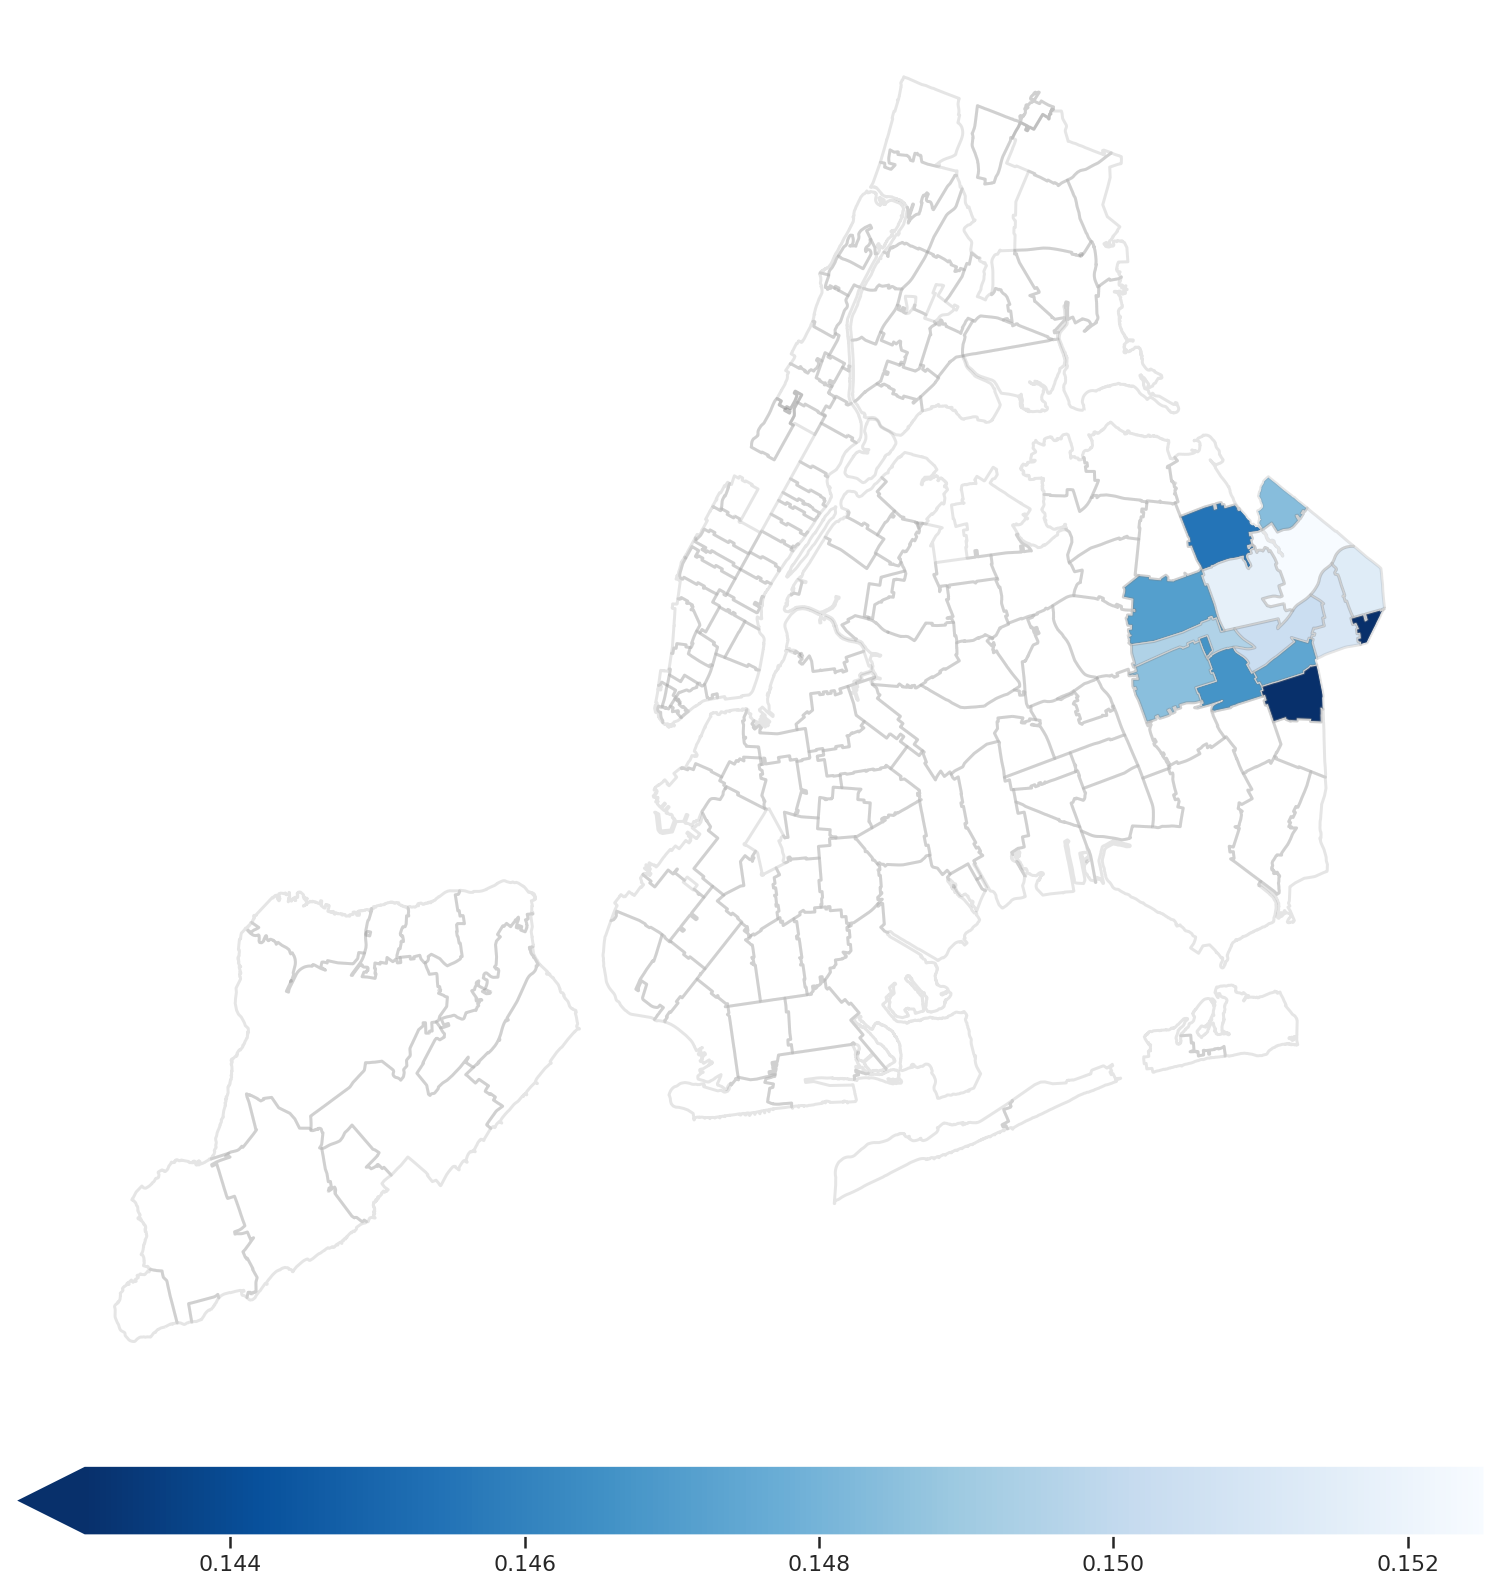

In [21]:
mapp(col=final_geo,name='bt_%_vacant_housing',color='Blues_r',normal=False)
